In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading Dataset


In [2]:
data = pd.read_csv('dataset/emails.csv')
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [3]:
data.shape

(5728, 2)

### Visualizing Dataset

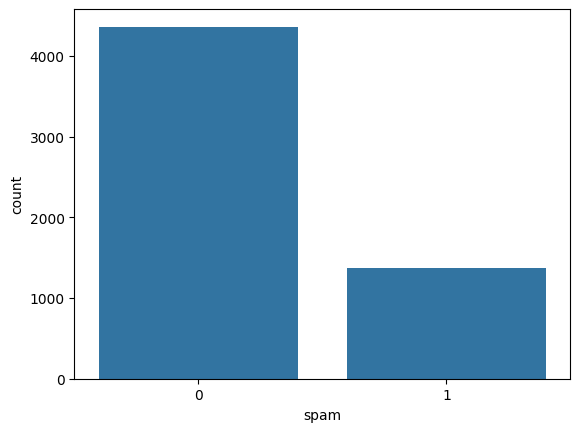

In [4]:
sns.countplot(x='spam', data=data)
plt.show()

### Downsampling to balance dataset for classification


In [5]:
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),
						random_state=42)

In [6]:
balanced_data = pd.concat([ham_msg, spam_msg])
balanced_data.head()

,text,spam
1547,Subject: interview schedule for jinbaek kim i...,0
2730,"Subject: re : wednesday meeting eric , i thi...",0
4843,Subject: re : london research group i ' d do ...,0
2856,"Subject: re : congratulations vince , thanks ...",0
3804,Subject: osman sezgen steve kromer is request...,0


### Visualizing the downsampled dataset

Text(0.5, 0, 'Message types')

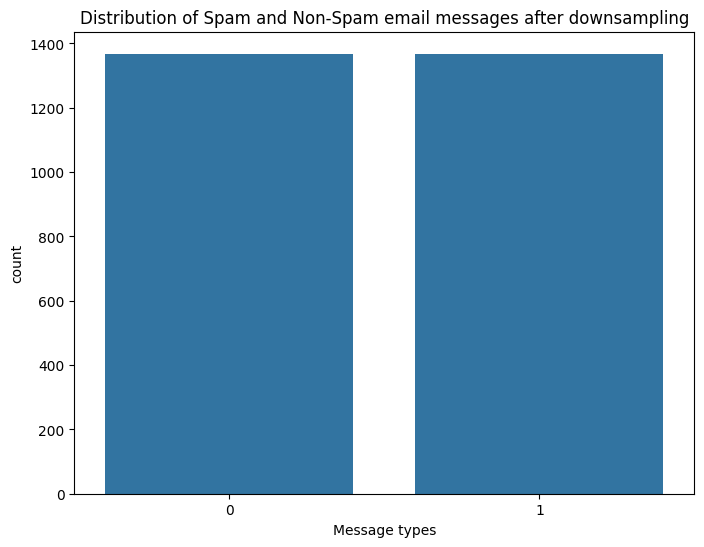

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Spam and Non-Spam email messages after downsampling')
plt.xlabel('Message types')

### Cleaning Data

#### Removing the words 'Subject' and 're' from email contents


In [8]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data['text'] = balanced_data['text'].str.replace('re', '')
balanced_data.head()

,text,spam
1547,: interview schedule for jinbaek kim i didn '...,0
2730,": : wednesday meeting eric , i think we can...",0
4843,: : london search group i ' d do it as soon ...,0
2856,": : congratulations vince , thanks for your ...",0
3804,: osman sezgen steve kromer is questing that ...,0


#### Removing all punctuation from email contents

In [9]:
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,text,spam
1547,interview schedule for jinbaek kim i didn t...,0
2730,wednesday meeting eric i think we can sk...,0
4843,london search group i d do it as soon as ...,0
2856,congratulations vince thanks for your not...,0
3804,osman sezgen steve kromer is questing that o...,0


#### Removing stopwords to end up with insightful keywords only

In [10]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')
    
    # list to store the important words
	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output

balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,text,spam
1547,interview schedule jinbaek kim see befo went h...,0
2730,wednesday meeting eric think skip meeting disc...,0
4843,london search group soon possible call exactly...,0
2856,congratulations vince thanks note congratulati...,0
3804,osman sezgen steve kromer questing osman spend...,0


### Visualizing using a wordcloud

#### helper function to plot the word cloud for spam and not spam emails


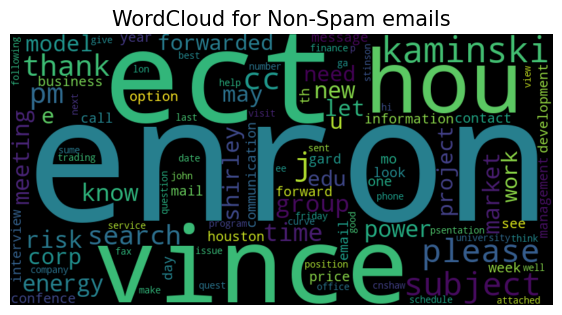

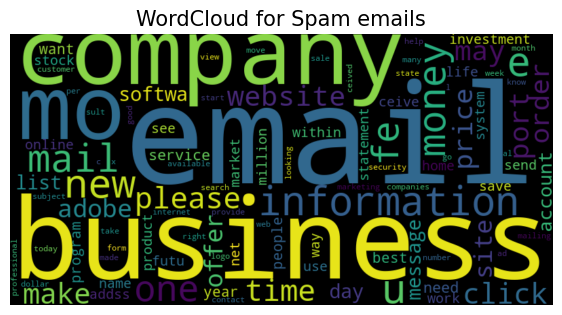

In [11]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['text'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')


### Train-Test Split


In [14]:
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
													balanced_data['spam'],
													test_size = 0.2,
													random_state = 42)

### Tokenizing Data

In [15]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len, 
								padding='post', 
								truncating='post')
test_sequences = pad_sequences(test_sequences, 
							maxlen=max_len, 
							padding='post', 
							truncating='post')

#### Checking the data status

In [16]:
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(balanced_data['text'].isnull().sum())  # Check for null or empty messages

Vocabulary size: 24803
0


### Building Model

In [24]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
									output_dim=32, 
									input_length=max_len))
model.add(LSTM(16))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

### Compiling Model

In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Defining Early Stopping and Learning Rate

In [26]:
es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)

### Training Model

In [27]:
history = model.fit(train_sequences, train_Y, 
                    validation_data=(test_sequences, test_Y),
                    epochs=10, 
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6069 - loss: 0.6817 - val_accuracy: 0.7062 - val_loss: 0.6290
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8270 - loss: 0.4793 - val_accuracy: 0.9526 - val_loss: 0.1900
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9691 - loss: 0.1342 - val_accuracy: 0.9599 - val_loss: 0.1664
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9741 - loss: 0.1129 - val_accuracy: 0.9544 - val_loss: 0.1804
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9753 - loss: 0.1069 - val_accuracy: 0.9690 - val_loss: 0.1377
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9849 - loss: 0.0728 - val_accuracy: 0.9635 - val_loss: 0.1801
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9899 - loss: 0.0522 - val_accuracy: 0.9672 - val_loss: 0.1656


### Model Summary

In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 32)             │         793,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,392,325 (9.13 MB)

 Trainable params: 797,441 (3.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,594,884 (6.08 MB)

### Model Evaluation

In [29]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9734 - loss: 0.1284
Test Loss : 0.16562293469905853
Test Accuracy : 0.9671533107757568


### Visualizing Model Accuracy

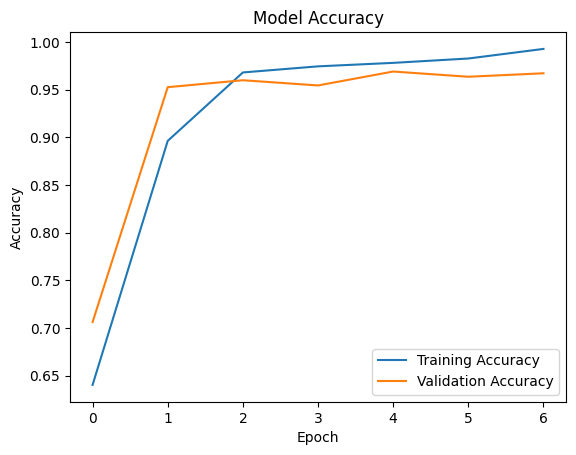

In [30]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()